In [10]:
from PIL import Image
import numpy as np
import scipy.io.wavfile as wav
import pyofdm.codec
import pyofdm.nyquistmodem
import matplotlib.pyplot as plt

In [11]:
# Number of total frequency samples
totalFreqSamples = 2048

# Number of useful data carriers / frequency samples
sym_slots = 1512

# QAM Order
QAMorder = 2

# Total number of bytes per OFDM symbol
nbytes = sym_slots * QAMorder // 8

# Distance of the evenly spaced pilots
distanceOfPilots = 12
pilotlist = pyofdm.codec.setpilotindex(nbytes, QAMorder, distanceOfPilots)

ofdm = pyofdm.codec.OFDM(pilotAmplitude=16/9, 
                         nData=nbytes, 
                         pilotIndices=pilotlist,
                         mQAM=QAMorder,
                         nFreqSamples=totalFreqSamples)

row = np.random.randint(256, size=nbytes, dtype="uint8")
complex_signal = ofdm.encode(row)

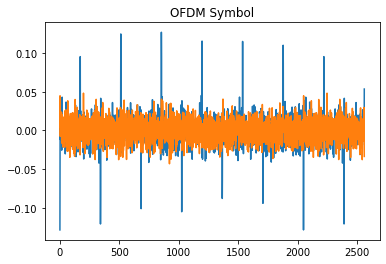

In [12]:
plt.figure()
plt.title("OFDM Symbol")
plt.plot(complex_signal.real)
plt.plot(complex_signal.imag)
plt.show()

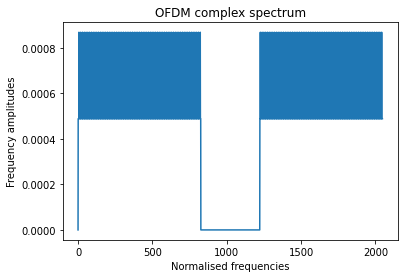

In [13]:
plt.figure()
plt.title("OFDM complex spectrum")
plt.xlabel("Normalised frequencies")
plt.ylabel("Frequency amplitudes")
plt.plot(np.abs(np.fft.fft(complex_signal[-totalFreqSamples:]) / totalFreqSamples))
plt.show()

In [14]:
# read image
img = Image.open("DC4_300x200.pgm")
tx_byte = np.array(img).ravel()

In [15]:
# append dummy bytes in order to make the data array is a whole multiple of nbytes
pad_num = nbytes - tx_byte.shape[0] % nbytes
tx_byte = np.pad(tx_byte, (0, pad_num), mode="constant", constant_values=127)

In [16]:
# OFDM encoding
complex_signal = np.array([ofdm.encode(tx_byte[i:i+nbytes])
                        for i in range(0, tx_byte.size, nbytes)]).ravel()

In [17]:
# modulate
base_signal = pyofdm.nyquistmodem.mod(complex_signal)

In [18]:
# add some random length dummy zero to the start of the signal
random_pad_length = 50
base_signal = np.pad(base_signal, (random_pad_length, 0), mode="constant")

In [19]:
# save it as a wav file
wav.write("ofdm44100.wav", 44100, base_signal)